
In this notebook, I have tested the performance of a pre - trained [xresnet50](https://docs.fast.ai/vision.models.xresnet.html#xresnet50) model on the [ImageWoof](https://github.com/fastai/imagenette#imagewoof) dataset.

The optimizer used is [ranger](https://docs.fast.ai/optimizer.html#ranger).

I have used [fastai](https://docs.fast.ai) for this project.

# 1. **Installing and importing the dependencies**

In [ ]:
!pip install fastai kornia -q --upgrade

     |████████████████████████████████| 186 kB 5.2 MB/s 
     |████████████████████████████████| 309 kB 41.2 MB/s 
     |████████████████████████████████| 56 kB 3.8 MB/s 


In [ ]:
from fastai.vision.all import *

# 2. **Downloading the ImageWoof dataset**

In [ ]:
path = untar_data(URLs.IMAGEWOOF)

# 3. **Data Preprocessing**

Each image in the dataset is first resized to 300 x 300, using the [Resize()](https://docs.fast.ai/vision.augment.html#Resize) class. Then, while training the model on each batch, each image, in the batch, is further reduced to the size of 224 x 224, alongwith normalizing them with Imagenet statistics, using [aug_transforms](https://docs.fast.ai/vision.augment.html#aug_transforms) and [Normalize](https://docs.fast.ai/data.transforms.html#Normalize), respectively.

Batch size is set to 64.

In [ ]:
item_tfms = Resize(size = 300)
batch_tfms = [*aug_transforms(size = 224, min_scale = 0.35), Normalize.from_stats(*imagenet_stats)]

In [ ]:
bs = 64 

In [ ]:
# From "https://walkwithfastai.com/ImageWoof"
label_to_dict = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

In [ ]:
imagewoof = DataBlock(blocks = (ImageBlock, CategoryBlock),
                      get_items = get_image_files,
                      splitter = GrandparentSplitter(valid_name = 'val'),
                      get_y = Pipeline([parent_label, label_to_dict.__getitem__]),
                      item_tfms = item_tfms,
                      batch_tfms = batch_tfms)

In [ ]:
dls = imagewoof.dataloaders(path, bs = bs)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


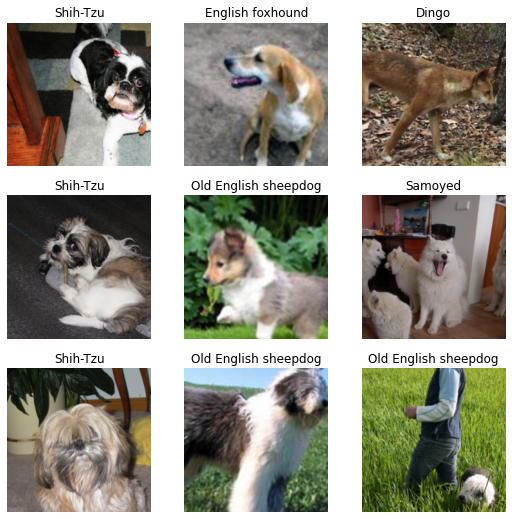

In [ ]:
dls.show_batch(max_n = 9)

# 4. **Model**

This model comprises :
1. Pre - trained XResNet - Based on the [Bag of Tricks](https://arxiv.org/pdf/1812.01187.pdf) for Resnet paper
2. [Mish](https://arxiv.org/vc/arxiv/papers/1908/1908.08681v1.pdf)- A new activation function that has shown fantastic results
3. Ranger - A new optimizer function based on two seperate papers:
 *   [On the Varience of the Adaptive Learning rate and Beyond, RAdam](https://arxiv.org/pdf/1908.03265.pdf)
 *   [Lookahead Optimizer: k steps forward, 1 step back](https://arxiv.org/pdf/1907.08610.pdf)
4. [Self-Attention](https://arxiv.org/pdf/1805.08318.pdf) - Bringing in ideas from GAN's into image classification (Incorportated by Seb)
5. [MaxBlurPool](https://arxiv.org/pdf/1904.11486.pdf) - Better generalization
6. Flatten + Anneal Scheduling - Mikhail Grankin
7. [Label Smoothing Cross Entropy](https://arxiv.org/pdf/1906.11567.pdf) - A threshold base (were you close) rather than yes or no

All of the above ideas are implemented in the library. However, coverting MaxPool2d to MaxBlurPool2d requires a custom function :

In [ ]:
# https://discuss.pytorch.org/t/how-can-i-replace-an-intermediate-layer-in-a-pre-trained-network/3586/7
import kornia
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model

In [ ]:
net = xresnet50(pretrained = True, act_cls = Mish, sa = True, n_out = dls.c)

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


  0%|          | 0.00/244M [00:00<?, ?B/s]

In [ ]:
net = convert_MP_to_blurMP(net, nn.MaxPool2d)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `MaxBlurPool2d` is deprecated and will be removed after > 0.6. Please use `kornia.filters.MaxBlurPool2D instead.`
  if sys.path[0] == '':


In [ ]:
learn = Learner(dls, model = net, loss_func = LabelSmoothingCrossEntropy(), metrics = accuracy, opt_func = ranger).to_fp16()

The full model has been unfrozen.

In [ ]:
learn.summary()

XResNet (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 112 x 112 
Conv2d                                    864        True      
BatchNorm2d                               64         True      
Mish                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
Mish                                                           
____________________________________________________________________________
                     64 x 64 x 112 x 112 
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
Mish                                                           
MaxBlurPool2d                                                  
Conv2d                                    4096       True      
BatchNorm2d                               128

I have used [lr_find()](https://docs.fast.ai/callback.schedule.html#Learner.lr_find) method for finding a suitable learning rate.

SuggestedLRs(valley=9.120108734350652e-05)

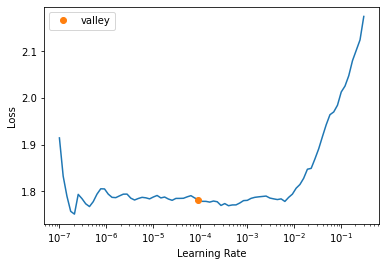

In [ ]:
learn.lr_find()

# 5. **Training and evaluation**

Here, I have trained (fine - tuned) the model for 2 epochs using the [fit_flat_cos()](https://docs.fast.ai/callback.schedule.html#Learner.fit_flat_cos) method.

In [ ]:
learn.fit_flat_cos(2, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.710871,1.965636,0.392721,04:47
1,1.580509,1.912066,0.437261,04:47



So, the accuracy after fine - tuning for 2 epochs is 43.72%

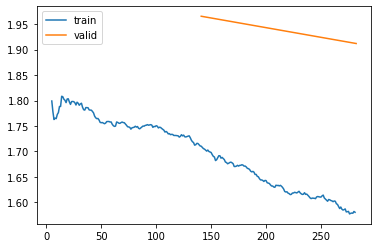

In [ ]:
learn.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

The confusion matrix :

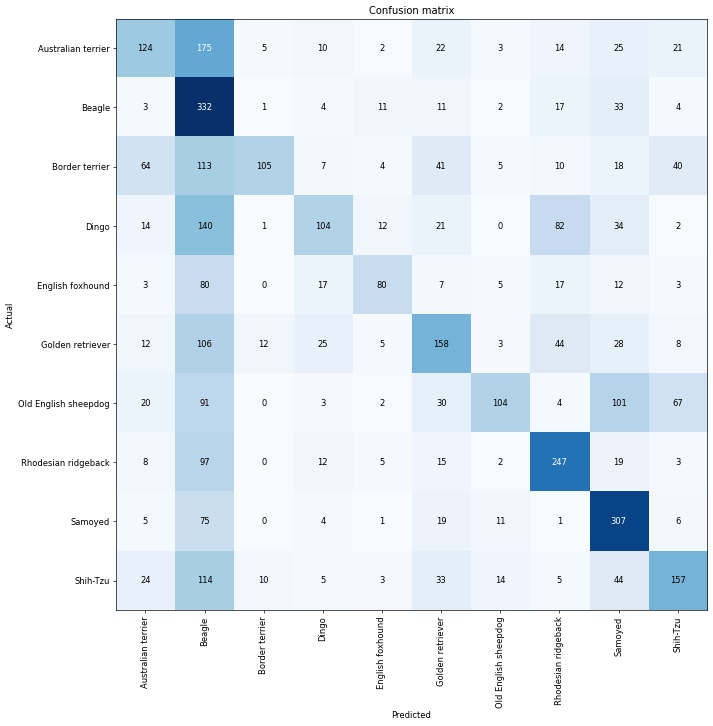

In [ ]:
interp.plot_confusion_matrix(figsize = (12, 12), dpi = 60)

In [ ]:
interp.most_confused(min_val = 20)

[('Australian terrier', 'Beagle', 175),
 ('Dingo', 'Beagle', 140),
 ('Shih-Tzu', 'Beagle', 114),
 ('Border terrier', 'Beagle', 113),
 ('Golden retriever', 'Beagle', 106),
 ('Old English sheepdog', 'Samoyed', 101),
 ('Rhodesian ridgeback', 'Beagle', 97),
 ('Old English sheepdog', 'Beagle', 91),
 ('Dingo', 'Rhodesian ridgeback', 82),
 ('English foxhound', 'Beagle', 80),
 ('Samoyed', 'Beagle', 75),
 ('Old English sheepdog', 'Shih-Tzu', 67),
 ('Border terrier', 'Australian terrier', 64),
 ('Golden retriever', 'Rhodesian ridgeback', 44),
 ('Shih-Tzu', 'Samoyed', 44),
 ('Border terrier', 'Golden retriever', 41),
 ('Border terrier', 'Shih-Tzu', 40),
 ('Dingo', 'Samoyed', 34),
 ('Beagle', 'Samoyed', 33),
 ('Shih-Tzu', 'Golden retriever', 33),
 ('Old English sheepdog', 'Golden retriever', 30),
 ('Golden retriever', 'Samoyed', 28),
 ('Australian terrier', 'Samoyed', 25),
 ('Golden retriever', 'Dingo', 25),
 ('Shih-Tzu', 'Australian terrier', 24),
 ('Australian terrier', 'Golden retriever', 22),


1. It takes very less time to fine - tune the pre - trained xresnet50 model on the ImageWoof dataset (around 5 minutes for each epoch).
2. Since, the training loss as well as the validation loss have decreased continuously for 2 epochs, it is better to train the model for more epochs in order to increase its accuracy. 
3. Fine - tuning pre - trained xresnet50 produces better results than fine - tuning it with adam.


In [ ]:
learn.save('stage - 1')

Path('models/stage - 1.pth')

Thanks a lot for taking the time to go through this notebook !